### Course: Bayesian Filtering and Smoothing.
### Exercise round: 7
### Student's name: Diego Alejandro Agudelo España.

### Exercise 2. (Smoother for Stochastic Resonator)

1. Implement the RTS smoother for the resonator model in Exercise 3 on Round 3.
2. Compare its RMSE performance to the filtering and baseline solutions and plot the results.

### Solution Exercise 2

In [7]:
%%script octave
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
% Becs-114.4610 - Special Course in Bayesian Modelling L:
% Bayesian Estimation of Time-Varying Processes (5 cr)
%
% This software is distributed under the GNU General Public 
% Licence (version 2 or later); please refer to the file 
% Licence.txt, included with the software, for details.
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%% Generate data

  % Lock random seed
  randn('state',12);
  
  % rmse function
  rmse = @(AA,BB) sum(sum((AA - BB) .* (AA - BB)));

  % Substitute Simo's 'gauss_rnd', where m is the mean and S the covariance
  gauss_rnd = @(m,S) m + chol(S)'*randn(size(m));
  
  % Define parameters
  steps = 100;  % Number of time steps
  w     = 0.5;  % Angular velocity
  q     = 0.01; % Process noise spectral density
  r     = 0.1;  % Measurement noise variance

  % This is the transition matrix
  A = [cos(w)    sin(w)/w; 
       -w*sin(w) cos(w)];

  % This is the process noise covariance
  Q = [0.5*q*(w-cos(w)*sin(w))/w^3 0.5*q*sin(w)^2/w^2;
       0.5*q*sin(w)^2/w^2          0.5*q*(w+cos(w)*sin(w))/w];

  % This is the true initial value
  x0 = [0;0.1]; 

  % Simulate data
  X = zeros(2,steps);  % The true signal
  Y = zeros(1,steps);  % Measurements
  T = 1:steps;         % Time
  x = x0;
  for k=1:steps
    x = gauss_rnd(A*x,Q);
    y = gauss_rnd(x(1),r);
    X(:,k) = x;
    Y(:,k) = y;
  end

  % Visualize
  figure; clf;
    plot(T,X(1,:),'--',T,Y,'o');
    legend('True signal','Measurements');
    xlabel('Time step'); title('\bf Simulated data')
    
  % Report and pause
  fprintf('This is the simulated data. Press enter.\n');
  pause;

  
%% Baseline solution

  % Baseline solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST1.
  
  % Calculate baseline estimate
  m1 = [0;1];  % Initialize first step with a guess
  EST1 = zeros(2,steps);
  for k=1:steps
    m1(2) = Y(k)-m1(1);
    m1(1) = Y(k);
    EST1(:,k) = m1;
  end

  % Visualize results
  figure; clf;
  
  % Plot the signal and its estimate
  subplot(2,1,1);
    plot(T,X(1,:),'--',T,EST1(1,:),'-',T,Y,'o');
    legend('True signal','Estimated signal','Measurements');
    xlabel('Time step'); title('\bf Baseline solution')
  
  % Plot the derivative and its estimate
  subplot(2,1,2);
    plot(T,X(2,:),'--',T,EST1(2,:),'-');
    legend('True derivative','Estimated derivative');
    xlabel('Time step')

  % Compute error
  err1 = rmse(X,EST1)
  
  % Report and pause
  fprintf('This is the base line estimate. Press enter.\n');
  pause
  
  
%% Kalman filter
  
  % Kalman filter solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST2.

  m2 = [0;1];  % Initialize first step
  P2 = eye(2); % Some uncertanty in covariance  
  EST2 = zeros(2,steps); % Allocate space for results
  H = [1, 0];
  
  % the following vectors are necessary for the smoother
  kf_m = zeros(size(m2, 1), steps);
  kf_P = zeros(size(m2, 1), size(m2, 1), steps);

  % Run Kalman filter
  for k=1:steps
    % Prediction step
    m2 = A * m2;
    P2 = A * P2 * A' + Q;
    % Update step
    vk = Y(k) - H * m2;
    Sk = H * P2 * H' + r;
    Kk = (P2 * H') / Sk;
    m2 = m2 + Kk * vk;
    P2 = P2 - Kk * Sk * Kk';
    % Store the results
    % disp(Kk);
    EST2(:,k) = m2;
    kf_m(:, k) = m2;
    kf_P(:, :, k) = P2;
  end

  % Visualize results
  figure; clf
  
  % Plot the signal and its estimate
  subplot(2,1,1);
    plot(T,X(1,:),'--',T,EST2(1,:),'-',T,Y,'o');
    legend('True signal','Estimated signal','Measurements');
    xlabel('Time step'); title('\bf Kalman filter')
  
  % Plot the derivative and its estimate
  subplot(2,1,2);
    plot(T,X(2,:),'--',T,EST2(2,:),'-');
    legend('True derivative','Estimated derivative');
    xlabel('Time step')

  % Compute error
  err2 = rmse(X,EST2)

  % Report and pause
  fprintf('This will be the KF estimate. Press enter.\n');
  pause;


%% RTS Smoother

  rts_m = zeros(size(m2, 1), steps);
  rts_P = zeros(size(m2, 1), size(m2, 1), steps);

  ms = m2;
  Ps = P2;
  
  rts_m(:, end) = ms;
  rts_P(:, :, end) = Ps;
  
  for k = steps - 1:-1:1
     % backward recursion
     mp = A * kf_m(:, k);
     Pp = A * kf_P(:,:, k) * A' + Q;
     G = kf_P(:,:, k) * A' / Pp;
     ms = kf_m(:, k) + G * (ms - mp);
     Ps = kf_P(:,:, k) + G * (Ps - Pp) * G';
     rts_m(:, k) = ms;
     rts_P(:,:, k) = Ps;
  end
  
  
  % Visualize results
  figure; clf
  
  % Plot the signal and its estimate
  subplot(2,1,1);
    plot(T,X(1,:),'--',T, rts_m(1,:),'-',T,Y,'o');
    legend('True signal','Estimated signal','Measurements');
    xlabel('Time step'); title('\bf RTS Smoother')
  
  % Plot the derivative and its estimate
  subplot(2,1,2);
    plot(T,X(2,:),'--',T, rts_m(2,:),'-');
    legend('True derivative','Estimated derivative');
    xlabel('Time step')
  saveas(gcf, 'R7_RTS_Smoother.png')

  % Compute error
  err3 = rmse(X, rts_m)

  % Report and pause
  fprintf('This will be the RTS Smoother estimate. Press enter.\n');
  pause;

GNU Octave, version 3.8.2
Copyright (C) 2014 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  For details, type 'warranty'.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at http://www.octave.org.

Please contribute if you find this software useful.
For more information, visit http://www.octave.org/get-involved.html

Read http://www.octave.org/bugs.html to learn how to submit bug reports.
For information about changes from previous versions, type 'news'.

This is the simulated data. Press enter.
err1 =  23.527
This is the base line estimate. Press enter.
err2 =  6.2974
This will be the KF estimate. Press enter.
err3 =  3.5506
This will be the RTS Smoother estimate. Press enter.


Some output formats are not available.


In [4]:
from IPython.display import Image

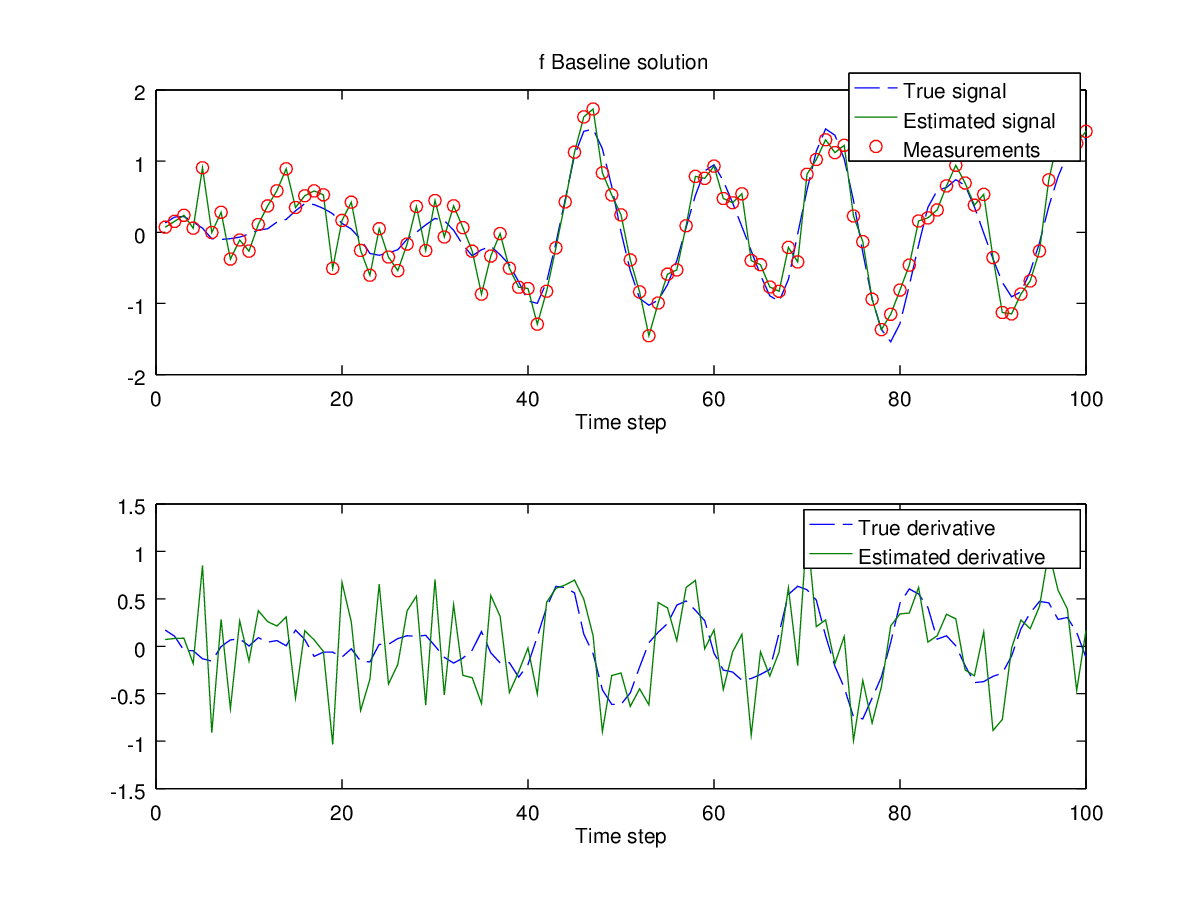

In [5]:
Image(filename='R2_BaseLine.png', width=700) 

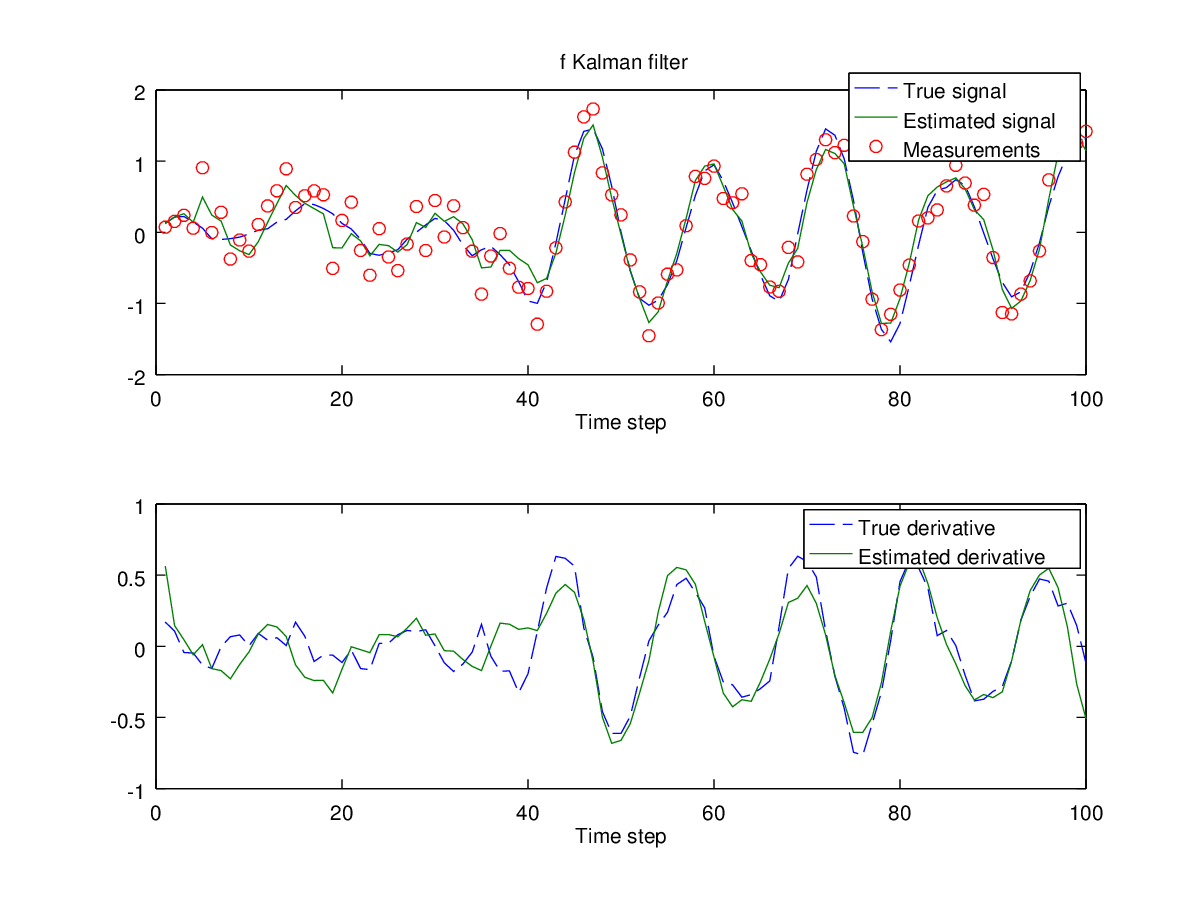

In [6]:
Image(filename='R2_KalmanFilter.png', width=700) 

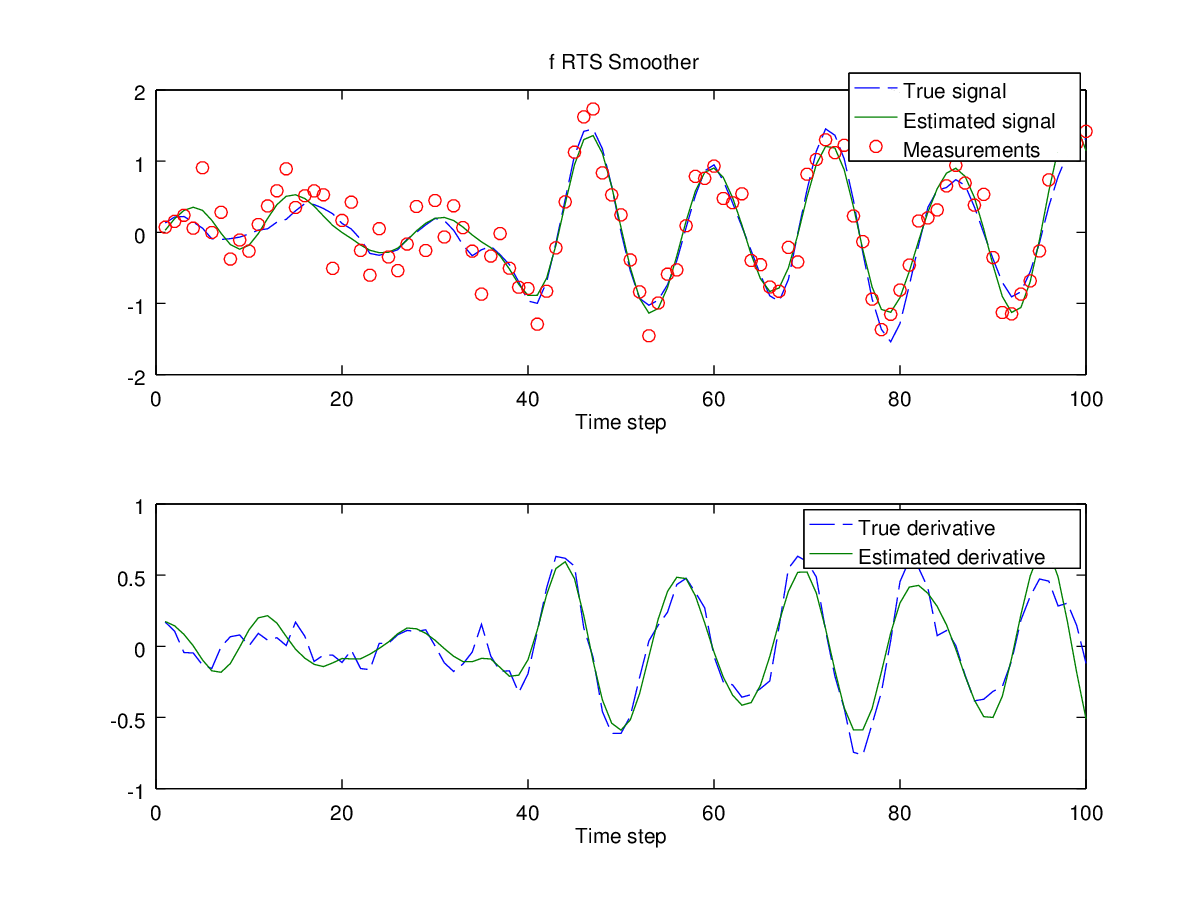

In [8]:
Image(filename='R7_RTS_Smoother.png', width=700) 

Method | RMSE
--- | --- 
Baseline Solution | 23.527
Kalman Filter | 6.2974
RTS Smoother |  3.5506